In [1]:
import numpy as np
import pandas as pd
import os 
import time
import deepdish.io as dd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

from svi import SVI
import models as m
import datasets as d

# Load and Prepare Data

In [2]:
data = dd.load("sequenced_data_for_VAE_lenght-160_stride-10.h5")

In [3]:
X,y = data["X"], data["y"]

In [4]:
X.shape

torch.Size([83680, 160])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.2, random_state=666, shuffle=True)

In [6]:
X_train.shape

(66944, 160)

In [7]:
y_train.shape

(66944,)

In [8]:
def RNNPreporces_batch(X, y, batch_size):
    length = (X.shape[0]//batch_size)*batch_size
    return X[:length, :], y[:length]

In [9]:
X_train, y_train = RNNPreporces_batch(X_train, y_train, batch_size=300)
X_test, y_test = RNNPreporces_batch(X_test, y_test, batch_size=300)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(66900, 160)
(66900,)
(16500, 160)
(16500,)


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
train = d.H_alphaSequences(X_train, y_train)
test = d.H_alphaSequences(X_test, y_test)

In [13]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=300, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size=300, shuffle=True)

# Model setup

In [14]:
torch.cuda.is_available()

True

In [15]:
torch.cuda.get_device_name()

'GeForce GTX 1070'

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
model_name = "DeepLSTM_VAE_MSE_150ep_lr-1e-3_bs-300"

In [18]:
#deepmodel.eval()

In [19]:
deepmodel = m.DeepLSTM_VAE_MSE(
                        sequence_len=160, 
                        n_features=1,
                        latent_dim=15,
                        hidden_size=128,
                        num_layers=2,
                        batch_size=300,
                        use_cuda=True
                        )
svi = SVI(
        vae_model=deepmodel,
        optimizer=torch.optim.Adam(deepmodel.parameters(), lr=1e-3),
        loss_function="MSE",
        verbose=True
        )

cuda:0


In [20]:
loss_hist = svi(epochs=150, train_loader=train_loader, validation_loader=test_loader, flatten=False)

Epoch [1/150], average_loss:123.9153, validation_loss:82.8012
Epoch [2/150], average_loss:86.2388, validation_loss:85.7845
Epoch [3/150], average_loss:86.1250, validation_loss:82.8576
Epoch [4/150], average_loss:63.1030, validation_loss:52.9198
Epoch [5/150], average_loss:48.6030, validation_loss:46.3484
Epoch [6/150], average_loss:46.5236, validation_loss:43.9878
Epoch [7/150], average_loss:45.5564, validation_loss:45.5582
Epoch [8/150], average_loss:45.8571, validation_loss:53.6958
Epoch [9/150], average_loss:49.1324, validation_loss:38.3334
Epoch [10/150], average_loss:32.3661, validation_loss:29.7487
Epoch [11/150], average_loss:30.3144, validation_loss:29.5340
Epoch [12/150], average_loss:29.8495, validation_loss:29.4422
Epoch [13/150], average_loss:31.5590, validation_loss:29.0754
Epoch [14/150], average_loss:29.3557, validation_loss:28.4842
Epoch [15/150], average_loss:29.0612, validation_loss:28.3791
Epoch [16/150], average_loss:28.9997, validation_loss:28.4023
Epoch [17/150], 

KeyboardInterrupt: 

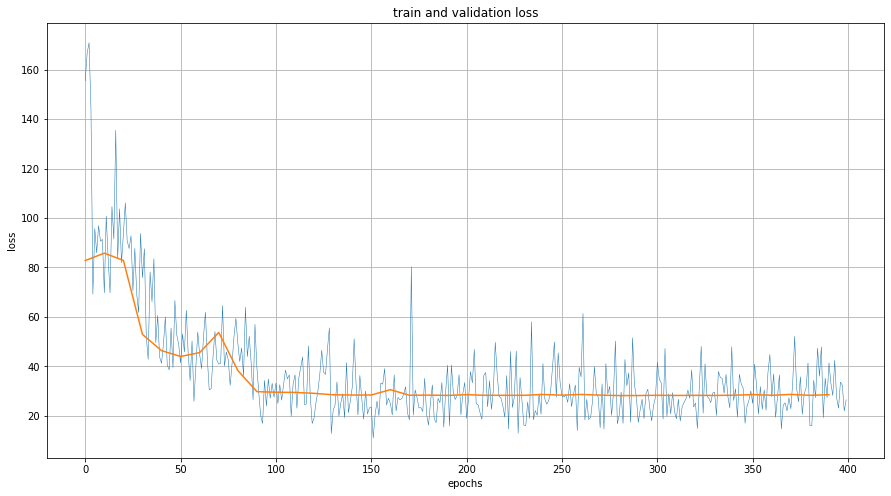

In [21]:
plt.figure(figsize=(15,8))
plt.title("train and validation loss")
epoch_axis = np.arange(len(svi.loss_history["train"]))
plt.plot(epoch_axis, np.array(svi.loss_history["train"]), lw=0.5) #np.arange(len(svi.loss_history["validation"]))*10
plt.plot(np.arange(len(svi.loss_history["validation"]))*10, svi.loss_history["validation"])
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
#torch.save(svi.model, f"VAE_saves_and_logs/{model_name}.pt")
#torch.save(svi.optimizer, f"VAE_saves_and_logs/{model_name}_optimizer.pt")
#dd.save(f"VAE_saves_and_logs/{model_name}_loss_history.h5", svi.loss_history)

# Evaluation

cuda:0


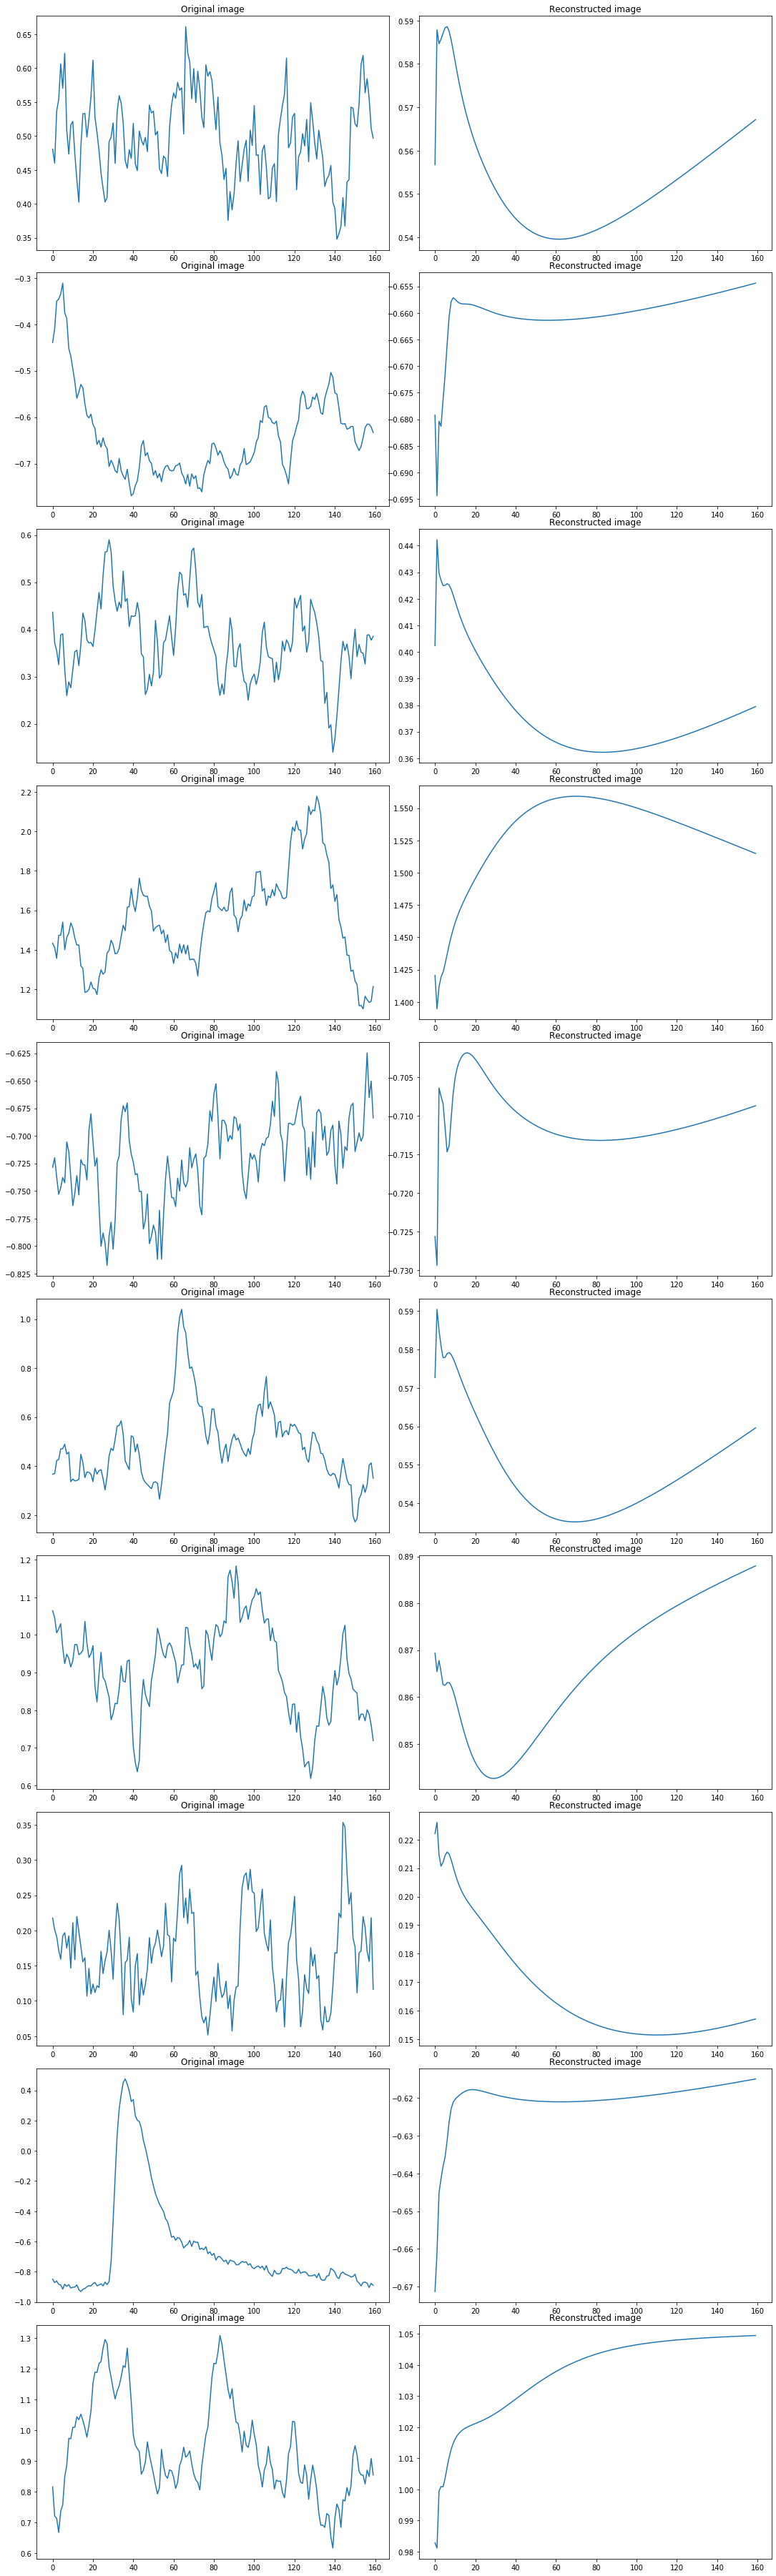

In [23]:
print(device)
X,_ = next(iter(test_loader))
output, mu, sigma = svi.model(X.to(device))
X_hat = output.cpu().detach().numpy()
#mu_hat = output[0].cpu().detach().numpy()
#sigma = output[1].cpu().detach().numpy()

fig, axes = plt.subplots(10, 2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
    axes[i][0].plot(X[i])
    axes[i][0].set_title('Original image')
    axes[i][1].plot(X_hat[i])
    #axes[i][1].plot(mu_hat[i])
    #axes[i][1].fill_between(np.arange(160), mu_hat[i] + 2 * sigma[i], mu_hat[i] - 2 * sigma[i], alpha = 0.5, label="Uncertainty")
    axes[i][1].set_title('Reconstructed image')

# Load Model

In [ ]:
mod = torch.load(f"VAE_saves_and_logs/{model_name}.pt")

In [ ]:
mod.eval()

In [ ]:
z, mu, sigma = mod.encoder(X.to(device))

In [ ]:
X_1, cl = test.X, test.y
Z_hat, mu, sigma = mod.encoder(X_1.to(device)) #.view(-1,28*28)
Z_hat = Z_hat.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Z_hat[:,0], Z_hat[:,1], Z_hat[:,2], c=cl, lw=3)
sc = ax.scatter(mu[:,0], mu[:,1], mu[:,2], c=cl, lw=3)

In [ ]:
# když přidám colorbar k obrázku tak se nehezky deformuje, tak je tady zvlášť
plt.colorbar(sc, shrink=1)

In [ ]:
test.y